In [1]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966 (90 deg)
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0 (0 deg)
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793 (180 deg)
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle

# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import WienerCascadeDecoder
from Neural_Decoding.decoders import WienerFilterDecoder
from Neural_Decoding.decoders import DenseNNDecoder
from Neural_Decoding.decoders import SimpleRNNDecoder
from Neural_Decoding.decoders import GRUDecoder
from Neural_Decoding.decoders import LSTMDecoder
from Neural_Decoding.decoders import XGBoostDecoder
from Neural_Decoding.decoders import SVRDecoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

def get_sses_pred(y_test,y_test_pred):
    sse=np.sum((y_test_pred-y_test)**2,axis=0)
    return sse

def get_sses_mean(y_test):
    y_mean=np.mean(y_test,axis=0)
    sse_mean=np.sum((y_test-y_mean)**2,axis=0)
    return sse_mean

def nans(shape, dtype=float):
    a = np.empty(shape, dtype)
    a.fill(np.nan)
    return a

def vector_reject(u,v):
    #project u on v, subtract u1 from u
    P = np.outer(v,(v.T))/(v@(v.T))
    u_sub = u - P@u
#     another calculation, to double-check
#     v_norm = np.sqrt(sum(v**2))    
#     proj_u_on_v = (np.dot(u, v)/v_norm**2)*v
#     u_sub = u - proj_u_on_v
    return u_sub

def calc_proj_matrix(A):
    return A@np.linalg.inv(A.T@A)@A.T
def calc_proj(b, A):
    P = calc_proj_matrix(A)
    return P@b.T

In [165]:
#define two lines in a 6D space and calculate projection matrix on the plane formed by them
#two lines must be linearly independent
A = np.matrix([[1,0,0,0,0,0],[0,1,0,0,0,0]]).T
print(A)
print(A.shape)
print()
print(calc_proj_matrix(A))
print()
print(calc_proj(np.array([0,0,1,0,0,0]),A))

[[1 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
(6, 2)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

[[0. 0. 0. 0. 0. 0.]]


# Single Lag

In [2]:
dataset_5ms = NWBDataset("~/area2_population_analysis/", "*train", split_heldout=False)
dataset_5ms.resample(5)
dataset_5ms.smooth_spk(40, name='smth_40')
bin_width = dataset_5ms.bin_width
print(bin_width)

5


In [3]:
n_dims = 20 # for PCA

active_mask = (~dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')
passive_mask = (dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')


trial_mask = active_mask
n_trials = dataset_5ms.trial_info.loc[trial_mask].shape[0]
print(n_trials,'trials')
n_neurons = dataset_5ms.data.spikes.shape[1]
print(n_neurons,'neurons')

all_data = np.array(dataset_5ms.data.spikes_smth_40)
print(all_data.shape)
data_for_pca = all_data[~np.isnan(all_data).any(axis=1)]
print(data_for_pca.shape)

scaler = StandardScaler()
X = scaler.fit_transform(data_for_pca)
pca = PCA(n_components=n_dims)
X = pca.fit(X)

PCA_data = nans([all_data.shape[0],n_dims])
idx = 0
for dp in all_data:
    dp = dp.reshape((1, -1))
    if np.isnan(dp).any():
        dp_pca = nans([1,n_dims])
    else:
        dp_pca = pca.transform(scaler.transform(dp))
    PCA_data[idx,:] = dp_pca
    idx+=1
print(PCA_data.shape)
dataset_5ms.add_continuous_data(PCA_data,'PCA')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))

#make dictionary for trial condition (reaching directions) for Stratified CV
active_trials_idx = np.array(dataset_5ms.trial_info.loc[trial_mask]['trial_id'])
cond_dir_idx = []
cond_dict = nans([n_trials])
for direction in [0,45,90,135,180,225,270,315]:
    cond_dir_idx.append(np.where((dataset_5ms.trial_info['cond_dir'] == direction) & (dataset_5ms.trial_info['ctr_hold_bump'] == False) & \
           (dataset_5ms.trial_info['split'] != 'none'))[0])
i = 0
for idx in active_trials_idx:
    for cond in range(0,len(cond_dir_idx)):
        if idx in cond_dir_idx[cond]:
            cond_dict[i] = cond
            break
    i+=1
print(cond_dict)

193 trials
65 neurons
(444690, 65)
(444493, 65)
(444690, 20)
PCA total var explained: 0.4733141277669527
[1. 1. 6. 4. 1. 4. 7. 0. 2. 5. 6. 2. 1. 1. 5. 7. 1. 1. 2. 2. 5. 0. 6. 0.
 0. 0. 3. 7. 7. 0. 7. 0. 3. 0. 7. 7. 5. 3. 0. 7. 3. 0. 6. 4. 3. 0. 0. 4.
 3. 3. 6. 1. 0. 2. 0. 6. 2. 0. 5. 4. 7. 6. 3. 1. 5. 3. 0. 4. 6. 6. 0. 1.
 3. 0. 6. 3. 1. 4. 3. 4. 5. 2. 2. 3. 3. 3. 4. 4. 2. 1. 2. 2. 4. 6. 1. 5.
 0. 2. 0. 4. 6. 5. 6. 3. 0. 0. 3. 3. 7. 5. 5. 3. 1. 5. 0. 7. 4. 7. 5. 5.
 1. 6. 3. 3. 2. 1. 7. 5. 5. 0. 1. 6. 2. 7. 1. 0. 0. 3. 4. 1. 2. 0. 3. 0.
 2. 5. 1. 3. 4. 1. 6. 5. 6. 3. 7. 5. 2. 0. 0. 5. 0. 6. 4. 2. 2. 7. 0. 4.
 4. 7. 5. 2. 6. 3. 2. 5. 5. 1. 1. 5. 5. 1. 6. 3. 7. 0. 4. 2. 1. 5. 1. 1.
 1.]


In [4]:
def process_train_test(X,y,training_set,test_set):
    X_train = X[training_set,:,:]
    X_test = X[test_set,:,:]
    y_train = y[training_set,:,:]
    y_test = y[test_set,:,:]

    #flat by trials
    X_flat_train = X_train.reshape((X_train.shape[0]*X_train.shape[1]),X_train.shape[2])
    X_flat_test = X_test.reshape((X_test.shape[0]*X_test.shape[1]),X_test.shape[2])
    y_train=y_train.reshape((y_train.shape[0]*y_train.shape[1]),y_train.shape[2])
    y_test=y_test.reshape((y_test.shape[0]*y_test.shape[1]),y_test.shape[2])
    
    X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
    X_flat_train_std=np.nanstd(X_flat_train,axis=0)   
    #array with only 0 will have 0 std and cause errors
    X_flat_train_std[X_flat_train_std==0] = 1
    
    X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
    X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
    y_train_mean=np.mean(y_train,axis=0)
    y_train=y_train-y_train_mean
    y_test=y_test-y_train_mean    
    
    return X_flat_train,X_flat_test,y_train,y_test

In [55]:
def fit_and_predict(dataset, trial_mask, align_field, align_range, lag, x_field, y_field):
    """Extracts spiking and kinematic data from selected trials and fits linear decoder"""
    # Extract rate data from selected trials
    vel_df = dataset.make_trial_data(align_field=align_field, align_range=align_range, ignored_trials=~trial_mask)
    # Lag alignment for kinematics and extract kinematics data from selected trials
    lag_align_range = (align_range[0] + lag, align_range[1] + lag)
    rates_df = dataset.make_trial_data(align_field=align_field, align_range=lag_align_range, ignored_trials=~trial_mask)
    
    n_trials = rates_df['trial_id'].nunique()
    n_timepoints = int((align_range[1] - align_range[0])/dataset.bin_width)
    n_neurons = rates_df[x_field].shape[1]
    
    lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)})
    rates_array = rates_df[x_field].to_numpy()
    vel_array = vel_df[y_field].to_numpy()
    lr_all.fit(rates_array, vel_array)
    
    rates_array = rates_array.reshape(n_trials, n_timepoints, n_neurons)
    vel_array = vel_array.reshape(n_trials, n_timepoints, 2)
    
    skf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)   
    true_concat = nans([n_trials*n_timepoints,2])
    pred_concat = nans([n_trials*n_timepoints,2])
    trial_save_idx = 0
    for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
        #split training and testing by trials
        X_train, X_test, y_train, y_test = process_train_test(rates_array,vel_array,training_set,test_set)
        lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)}) 
        lr.fit(X_train, y_train)
        y_test_predicted = lr.predict(X_test)
        
        n = y_test_predicted.shape[0]
        true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
        pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
        trial_save_idx += n
    
    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    print('R2:',R2) 
    return R2, lr_all.best_estimator_.coef_

In [112]:
def sub_and_predict(dataset, trial_mask, align_field, align_range, lag, x_field, y_field, weights):
    """Extracts spiking and kinematic data from selected trials and fits linear decoder"""
    # Extract rate data from selected trials
    vel_df = dataset.make_trial_data(align_field=align_field, align_range=align_range, ignored_trials=~trial_mask)
    # Lag alignment for kinematics and extract kinematics data from selected trials
    lag_align_range = (align_range[0] + lag, align_range[1] + lag)
    rates_df = dataset.make_trial_data(align_field=align_field, align_range=lag_align_range, ignored_trials=~trial_mask)
    
    n_trials = rates_df['trial_id'].nunique()
    n_timepoints = int((align_range[1] - align_range[0])/dataset.bin_width)
    n_neurons = rates_df[x_field].shape[1]

    rates_array = rates_df[x_field].to_numpy() - calc_proj(rates_df[x_field].to_numpy(),weights.T).T
    vel_array = vel_df[y_field].to_numpy()
    
    lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)})
    lr_all.fit(rates_array, vel_array)
    
    rates_array = rates_array.reshape(n_trials, n_timepoints, n_neurons)
    vel_array = vel_array.reshape(n_trials, n_timepoints, 2)
    
    skf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)   
    true_concat = nans([n_trials*n_timepoints,2])
    pred_concat = nans([n_trials*n_timepoints,2])
    trial_save_idx = 0
    for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
        #split training and testing by trials
        X_train, X_test, y_train, y_test = process_train_test(rates_array,vel_array,training_set,test_set)
        lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)}) 
        lr.fit(X_train, y_train)
        y_test_predicted = lr.predict(X_test)
        
        n = y_test_predicted.shape[0]
        true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
        pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
        trial_save_idx += n
    
    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    print('R2:',R2) 
    return R2, lr_all.best_estimator_.coef_

## with Neurons

In [119]:
lag_axis = np.arange(-300,300,20)
x_field = 'spikes_smth_40'
y_field ='hand_vel'
trial_mask = active_mask

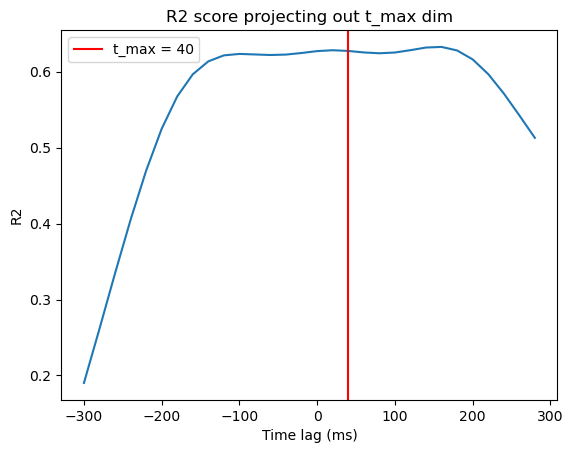

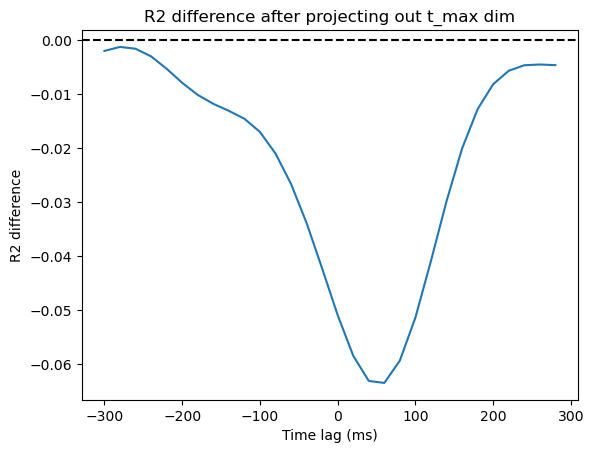

In [114]:
n_timepoints = int((500 - (-100))/dataset_5ms.bin_width)
whole_r2_array = nans([len(lag_axis)])
whole_coef_array = nans([len(lag_axis),2,n_neurons])
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, coef = fit_and_predict(dataset_5ms, trial_mask, 'move_onset_time', (-100, 500), lag, x_field, y_field)
    whole_r2_array[i] = r2
    whole_coef_array[i,:,:] = coef

curr_r2_array = whole_r2_array
curr_coef_array = whole_coef_array
    
idx_max = np.argmax(curr_r2_array)
time_max = lag_axis[idx_max]

plt.plot(lag_axis, curr_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score with different time lags, \n predicting hand velocity [-100,500]')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

ang_dist_to_max = nans([len(lag_axis)])
for i in range(0, len(curr_coef_array)):
    ang_dist_to_max[i] = math.degrees(angle_between(curr_coef_array[i,0,:],curr_coef_array[idx_max,0,:]))
plt.scatter(lag_axis, ang_dist_to_max)
plt.title('Angular distance to X-vel decoding dim at t_max')
plt.xlabel('Time lag (ms)')
plt.ylabel('Angular distance (degrees)')
plt.show()


#subtract predictions with primary decoding dimensions (at time with max R2)
sub_coef_array = nans([len(lag_axis),2,curr_coef_array.shape[2]])
sub_r2_array = nans([len(lag_axis)])
weights = curr_coef_array[idx_max,:,:]
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, coef = sub_and_predict(dataset_5ms, trial_mask, 'move_onset_time', (-100, 500), lag,x_field,y_field,weights)
    sub_r2_array[i] = r2
    sub_coef_array[i,:,:] = coef

plt.plot(lag_axis,sub_r2_array)
plt.title('R2 score projecting out t_max dim')
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

plt.plot(lag_axis,np.subtract(sub_r2_array,curr_r2_array))
plt.axhline(0,color = 'k',linestyle='--')
plt.title('R2 difference after projecting out t_max dim')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2 difference')
plt.show()



R2: -0.4276468124982542
R2: -0.47715187031641015
R2: -0.5134009631043281
R2: -0.45571064995778277
R2: -0.2912440593061021
R2: -0.08982392239901293
R2: 0.10359740581061516
R2: 0.30708024861930194
R2: 0.48422031003345134
R2: 0.6010830045596705
R2: 0.66130582307556
R2: 0.684315412036044
R2: 0.6851699223577628
R2: 0.669914051122481
R2: 0.6435185751569671
R2: 0.6211796712482138
R2: 0.6285182146117947
R2: 0.6465969223014312
R2: 0.6637254777522463
R2: 0.6855008555536962
R2: 0.7033331171066641
R2: 0.7076425564952159
R2: 0.7020641255523217
R2: 0.7058408305604209
R2: 0.6999419893794057
R2: 0.681017038913735
R2: 0.6675743434434549
R2: 0.659530077926767
R2: 0.6474363431505126
R2: 0.6273838217304841


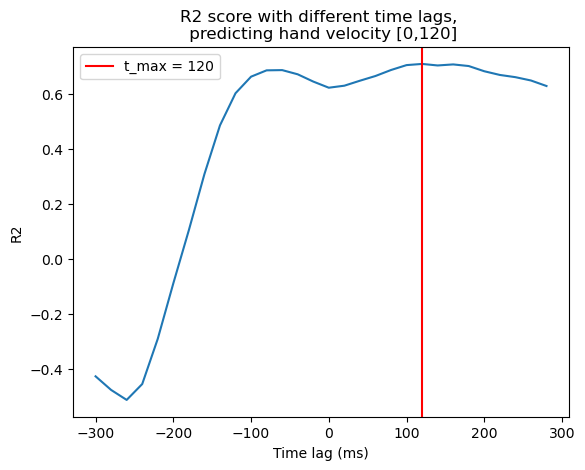

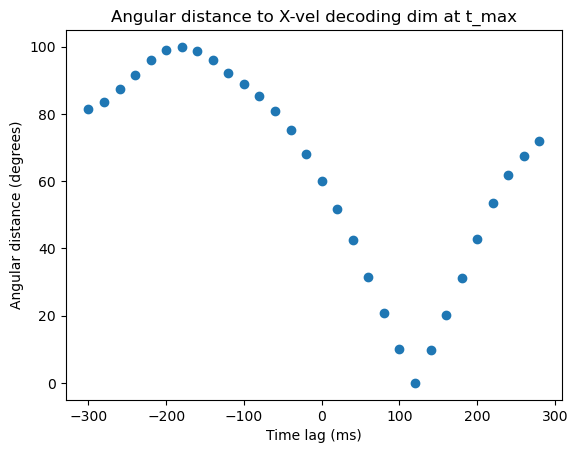

R2: -0.4068736702617919
R2: -0.43774034314594235
R2: -0.45726437439366374
R2: -0.42771285925654423
R2: -0.29749002462049257
R2: -0.09632032620686615
R2: 0.1100522154280511
R2: 0.3086246202209555
R2: 0.4798276561613448
R2: 0.5988597029130083
R2: 0.6644406534903077
R2: 0.6905002427402583
R2: 0.6930053330878745
R2: 0.6797890403358071
R2: 0.6512082112386028
R2: 0.6224838433566247
R2: 0.6106511097523477
R2: 0.5995894563581106
R2: 0.5687335889421261
R2: 0.5439651710714739
R2: 0.5373407897466065
R2: 0.4949762635481969
R2: 0.47298370176484783
R2: 0.4989194556796941
R2: 0.5147338626865288
R2: 0.6034375092423807
R2: 0.6296460281176909
R2: 0.6084363254027134
R2: 0.5696932927377809
R2: 0.5692077629888295


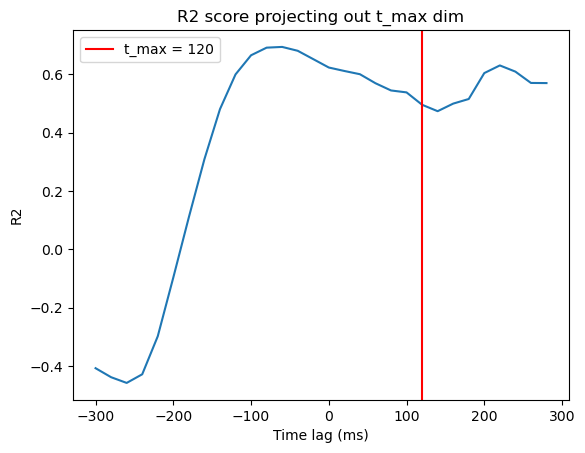

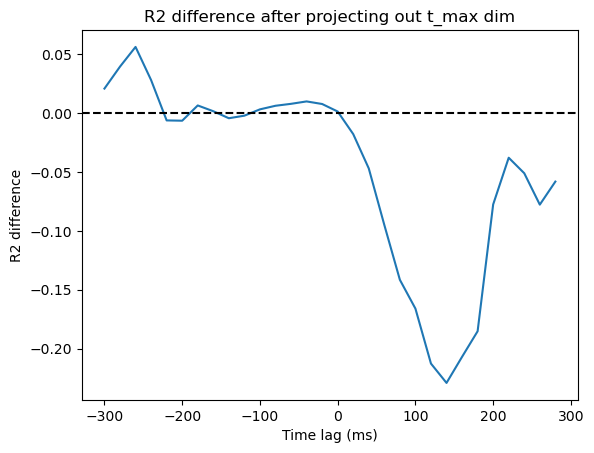

In [120]:
n_timepoints = int((120 - (-0))/dataset_5ms.bin_width)
early_r2_array = nans([len(lag_axis)])
early_coef_array = nans([len(lag_axis),2,n_neurons])
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, coef = fit_and_predict(dataset_5ms, trial_mask, 'move_onset_time', (0, 120), lag, x_field, y_field)
    early_r2_array[i] = r2
    early_coef_array[i,:,:] = coef

curr_r2_array = early_r2_array
curr_coef_array = early_coef_array
    
idx_max = np.argmax(curr_r2_array)
time_max = lag_axis[idx_max]

plt.plot(lag_axis, curr_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score with different time lags, \n predicting hand velocity [0,120]')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

ang_dist_to_max = nans([len(lag_axis)])
for i in range(0, len(curr_coef_array)):
    ang_dist_to_max[i] = math.degrees(angle_between(curr_coef_array[i,0,:],curr_coef_array[idx_max,0,:]))
plt.scatter(lag_axis, ang_dist_to_max)
plt.title('Angular distance to X-vel decoding dim at t_max')
plt.xlabel('Time lag (ms)')
plt.ylabel('Angular distance (degrees)')
plt.show()


#subtract predictions with primary decoding dimensions (at time with max R2)
sub_coef_array = nans([len(lag_axis),2,curr_coef_array.shape[2]])
sub_r2_array = nans([len(lag_axis)])
weights = curr_coef_array[idx_max,:,:]
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, coef = sub_and_predict(dataset_5ms, trial_mask, 'move_onset_time', (0, 120), lag,x_field,y_field,weights)
    sub_r2_array[i] = r2
    sub_coef_array[i,:,:] = coef

plt.plot(lag_axis,sub_r2_array)
plt.title('R2 score projecting out t_max dim')
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

plt.plot(lag_axis,np.subtract(sub_r2_array,curr_r2_array))
plt.axhline(0,color = 'k',linestyle='--')
plt.title('R2 difference after projecting out t_max dim')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2 difference')
plt.show()



## with PCA

In [121]:
x_field = 'PCA'
y_field ='hand_vel'
lag_axis = np.arange(-300,300,20)

R2: 0.16926638453538245
R2: 0.22029478833187854
R2: 0.2751081343684477
R2: 0.3305545547421056
R2: 0.38331140670556774
R2: 0.43020201166382965
R2: 0.4687013249205656
R2: 0.49789306976604764
R2: 0.5188725731478733
R2: 0.5340501925303816
R2: 0.5464895193591877
R2: 0.559390976888541
R2: 0.574762521284384
R2: 0.5924019523982605
R2: 0.6100953907787372
R2: 0.6247688971742058
R2: 0.6339198270111552
R2: 0.6364417136485132
R2: 0.6329398061774427
R2: 0.6255929495110394
R2: 0.6169821392299843
R2: 0.6085971966531041
R2: 0.6003625608870682
R2: 0.59112722312307
R2: 0.579182863319129
R2: 0.5628410733233391
R2: 0.5413946104413258
R2: 0.5156304949027615
R2: 0.48748924238695024
R2: 0.4590968165732241


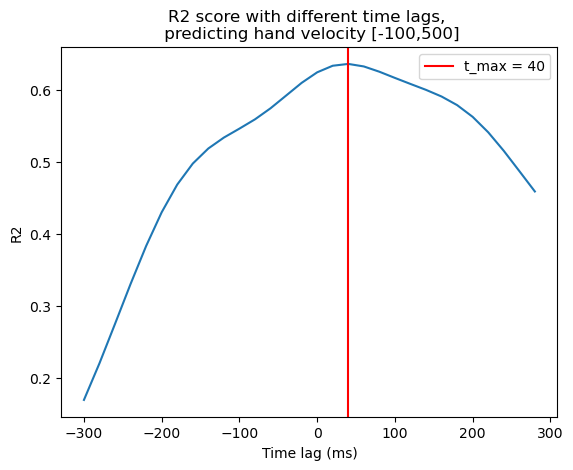

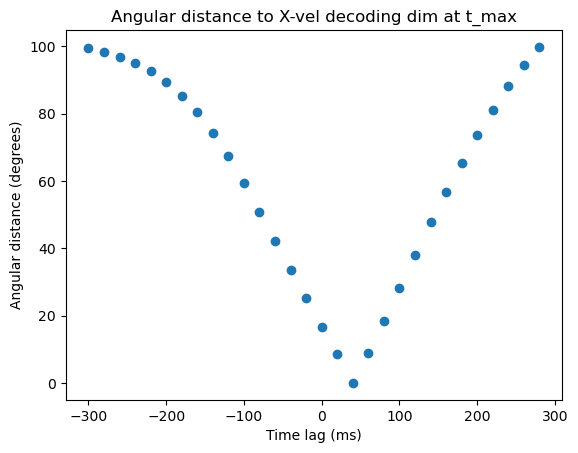

R2: 0.1605443616136163
R2: 0.20657490565892878
R2: 0.2565845021551122
R2: 0.3074084510534667
R2: 0.35507696244853304
R2: 0.3952847129454039
R2: 0.42400308737938686
R2: 0.438541404688334
R2: 0.438189765169841
R2: 0.42371933026653974
R2: 0.3972512986108919
R2: 0.36267347143165685
R2: 0.32502583207159397
R2: 0.2895965600192285
R2: 0.2613772829044275
R2: 0.24429879058354997
R2: 0.2405536039372611
R2: 0.25066066369334006
R2: 0.27380627034595295
R2: 0.3082092044412782
R2: 0.35111620922122355
R2: 0.3983035352070907
R2: 0.44432075539415705
R2: 0.48386084462555967
R2: 0.5124644742587523
R2: 0.5266122107223128
R2: 0.5248920201750826
R2: 0.5089949616752478
R2: 0.4830657594844776
R2: 0.45184399812729625


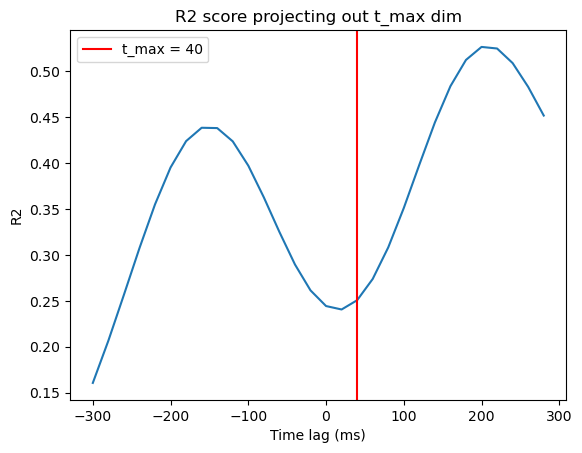

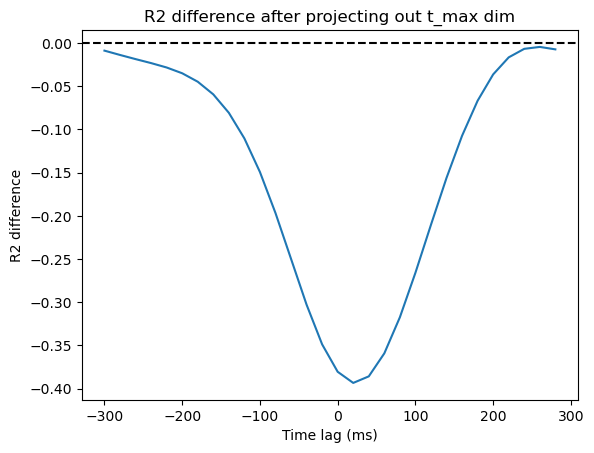

In [117]:
n_timepoints = int((500 - (-100))/dataset_5ms.bin_width)
PCA_whole_r2_array = nans([len(lag_axis)])
PCA_whole_coef_array = nans([len(lag_axis),2,n_dims])
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, coef = fit_and_predict(dataset_5ms, trial_mask, 'move_onset_time', (-100, 500), lag, x_field, y_field)
    PCA_whole_r2_array[i] = r2
    PCA_whole_coef_array[i,:,:] = coef

curr_r2_array = PCA_whole_r2_array
curr_coef_array = PCA_whole_coef_array
    
idx_max = np.argmax(curr_r2_array)
time_max = lag_axis[idx_max]

plt.plot(lag_axis, curr_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score with different time lags, \n predicting hand velocity [-100,500]')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

ang_dist_to_max = nans([len(lag_axis)])
for i in range(0, len(curr_coef_array)):
    ang_dist_to_max[i] = math.degrees(angle_between(curr_coef_array[i,0,:],curr_coef_array[idx_max,0,:]))
plt.scatter(lag_axis, ang_dist_to_max)
plt.title('Angular distance to X-vel decoding dim at t_max')
plt.xlabel('Time lag (ms)')
plt.ylabel('Angular distance (degrees)')
plt.show()


#subtract predictions with primary decoding dimensions (at time with max R2)
sub_coef_array = nans([len(lag_axis),2,curr_coef_array.shape[2]])
sub_r2_array = nans([len(lag_axis)])
weights = curr_coef_array[idx_max,:,:]
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, coef = sub_and_predict(dataset_5ms, trial_mask, 'move_onset_time', (-100, 500), lag,x_field,y_field,weights)
    sub_r2_array[i] = r2
    sub_coef_array[i,:,:] = coef

plt.plot(lag_axis,sub_r2_array)
plt.title('R2 score projecting out t_max dim')
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

plt.plot(lag_axis,np.subtract(sub_r2_array,curr_r2_array))
plt.axhline(0,color = 'k',linestyle='--')
plt.title('R2 difference after projecting out t_max dim')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2 difference')
plt.show()



R2: -0.0911358564997069
R2: -0.08244278596352328
R2: -0.08224063912910129
R2: -0.07709864012828715
R2: -0.04309325343851289
R2: 0.041221107116631295
R2: 0.169776146105295
R2: 0.3075218216916975
R2: 0.4278585554769858
R2: 0.5220105329781106
R2: 0.5828298545332655
R2: 0.6089124278500804
R2: 0.611912978283986
R2: 0.6095871551436681
R2: 0.6149220703414788
R2: 0.6256408553103577
R2: 0.6341103077371399
R2: 0.6401741181703144
R2: 0.649059072804198
R2: 0.6627804496357423
R2: 0.6796375855734388
R2: 0.6942450740586923
R2: 0.7017582593055982
R2: 0.7011897009550001
R2: 0.6937982048878797
R2: 0.6821841911078218
R2: 0.6688542447349657
R2: 0.6559938997400201
R2: 0.6443081891446909
R2: 0.6321562504037369


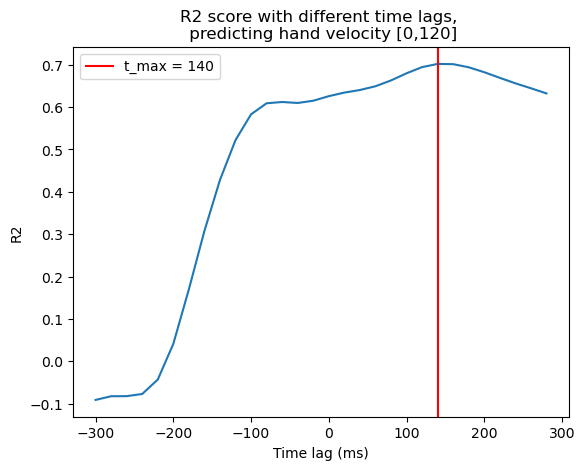

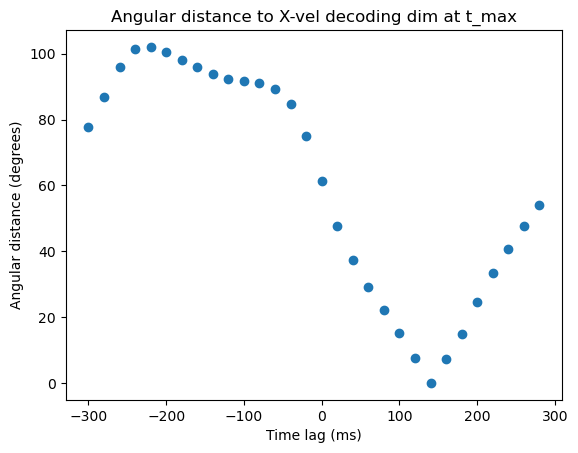

R2: -0.08205719390048816
R2: -0.0748358367472457
R2: -0.07069304720383562
R2: -0.06327373623853338
R2: -0.03039041976338308
R2: 0.05139324318499905
R2: 0.17599777212491208
R2: 0.3102146274780392
R2: 0.42688114676542066
R2: 0.5181102898710861
R2: 0.5783604712911123
R2: 0.6053978321955004
R2: 0.610765089138023
R2: 0.6101927902450097
R2: 0.6114330544964882
R2: 0.6087677093622581
R2: 0.5932103229009407
R2: 0.563641131046806
R2: 0.5299899776153724
R2: 0.5055352946836543
R2: 0.49200517320459014
R2: 0.4830254412297993
R2: 0.47840881340092034
R2: 0.48026668283632623
R2: 0.48509161175431004
R2: 0.48479807145257525
R2: 0.47815118433134574
R2: 0.47669734032360633
R2: 0.49114087167409215
R2: 0.515680636762752


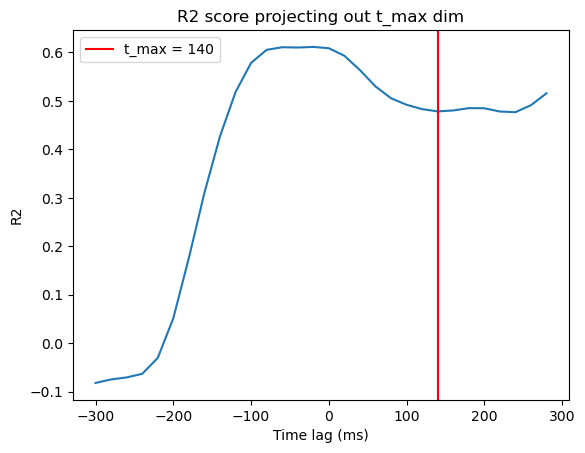

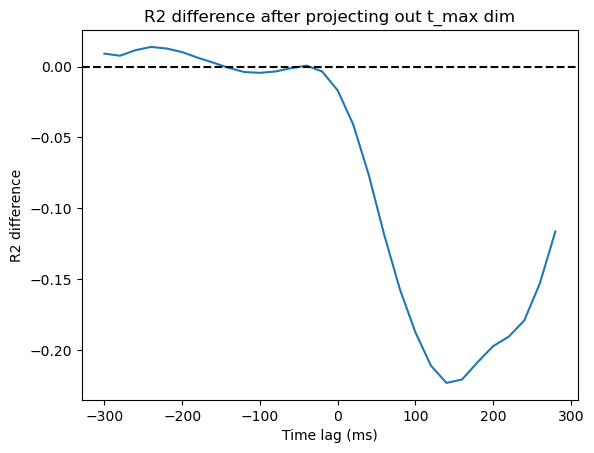

In [122]:
n_timepoints = int((120 - (-0))/dataset_5ms.bin_width)
PCA_early_r2_array = nans([len(lag_axis)])
PCA_early_coef_array = nans([len(lag_axis),2,n_dims])
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, coef = fit_and_predict(dataset_5ms, trial_mask, 'move_onset_time', (0, 120), lag, x_field, y_field)
    PCA_early_r2_array[i] = r2
    PCA_early_coef_array[i,:,:] = coef

curr_r2_array = PCA_early_r2_array
curr_coef_array = PCA_early_coef_array
    
idx_max = np.argmax(curr_r2_array)
time_max = lag_axis[idx_max]

plt.plot(lag_axis, curr_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score with different time lags, \n predicting hand velocity [0,120]')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

ang_dist_to_max = nans([len(lag_axis)])
for i in range(0, len(curr_coef_array)):
    ang_dist_to_max[i] = math.degrees(angle_between(curr_coef_array[i,0,:],curr_coef_array[idx_max,0,:]))
plt.scatter(lag_axis, ang_dist_to_max)
plt.title('Angular distance to X-vel decoding dim at t_max')
plt.xlabel('Time lag (ms)')
plt.ylabel('Angular distance (degrees)')
plt.show()


#subtract predictions with primary decoding dimensions (at time with max R2)
sub_coef_array = nans([len(lag_axis),2,curr_coef_array.shape[2]])
sub_r2_array = nans([len(lag_axis)])
weights = curr_coef_array[idx_max,:,:]
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, coef = sub_and_predict(dataset_5ms, trial_mask, 'move_onset_time', (0, 120), lag,x_field,y_field,weights)
    sub_r2_array[i] = r2
    sub_coef_array[i,:,:] = coef

plt.plot(lag_axis,sub_r2_array)
plt.title('R2 score projecting out t_max dim')
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

plt.plot(lag_axis,np.subtract(sub_r2_array,curr_r2_array))
plt.axhline(0,color = 'k',linestyle='--')
plt.title('R2 difference after projecting out t_max dim')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2 difference')
plt.show()



# Multi Lags

In [123]:
dataset_50ms = NWBDataset("~/area2_population_analysis/", "*train", split_heldout=False)
dataset_50ms.resample(50)
print(dataset_50ms.bin_width)

50


In [124]:
n_dims = 20 # for PCA

active_mask = (~dataset_50ms.trial_info.ctr_hold_bump) & (dataset_50ms.trial_info.split != 'none')
passive_mask = (dataset_50ms.trial_info.ctr_hold_bump) & (dataset_50ms.trial_info.split != 'none')


trial_mask = active_mask
n_trials = dataset_50ms.trial_info.loc[trial_mask].shape[0]
print(n_trials,'trials')
n_neurons = dataset_50ms.data.spikes.shape[1]
print(n_neurons,'neurons')

all_data = np.array(dataset_50ms.data.spikes)
print(all_data.shape)
data_for_pca = all_data[~np.isnan(all_data).any(axis=1)]
print(data_for_pca.shape)

scaler = StandardScaler()
X = scaler.fit_transform(data_for_pca)
pca = PCA(n_components=n_dims)
X = pca.fit(X)

PCA_data = nans([all_data.shape[0],n_dims])
idx = 0
for dp in all_data:
    dp = dp.reshape((1, -1))
    if np.isnan(dp).any():
        dp_pca = nans([1,n_dims])
    else:
        dp_pca = pca.transform(scaler.transform(dp))
    PCA_data[idx,:] = dp_pca
    idx+=1
print(PCA_data.shape)
dataset_50ms.add_continuous_data(PCA_data,'PCA')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))

193 trials
65 neurons
(44469, 65)
(44465, 65)
(44469, 20)
PCA total var explained: 0.40155551517275945


In [125]:
active_data = dataset_50ms.make_trial_data(align_field='move_onset_time', align_range=(-300, 700), ignored_trials=~trial_mask)
for idx, trial in active_data.groupby('trial_id'):
    n_timepoints = trial.shape[0]
    break
print(n_timepoints,'time bins')

active_trials_neuron = nans([n_trials,n_timepoints,n_neurons])
active_trials_vel = nans([n_trials,n_timepoints,2])
active_trials_pca = nans([n_trials,n_timepoints,n_dims])
i = 0
for idx, trial in active_data.groupby('trial_id'):
    active_trials_neuron[i,:,:]=trial.spikes.to_numpy()
    active_trials_vel[i,:,:]=trial.hand_vel.to_numpy()
    active_trials_pca[i,:,:]=trial.PCA.to_numpy()
    i+=1
print(active_trials_neuron.shape)
print(active_trials_vel.shape)
print(active_trials_pca.shape)

#make dictionary for trial condition (reaching directions) for Stratified CV
active_trials_idx = np.array(dataset_50ms.trial_info.loc[trial_mask]['trial_id'])
cond_dir_idx = []
cond_dict = nans([n_trials])
for direction in [0,45,90,135,180,225,270,315]:
    cond_dir_idx.append(np.where((dataset_50ms.trial_info['cond_dir'] == direction) & (dataset_50ms.trial_info['ctr_hold_bump'] == False) & \
           (dataset_50ms.trial_info['split'] != 'none'))[0])
i = 0
for idx in active_trials_idx:
    for cond in range(0,len(cond_dir_idx)):
        if idx in cond_dir_idx[cond]:
            cond_dict[i] = cond
            break
    i+=1
print(cond_dict)

20 time bins
(193, 20, 65)
(193, 20, 2)
(193, 20, 20)
[1. 1. 6. 4. 1. 4. 7. 0. 2. 5. 6. 2. 1. 1. 5. 7. 1. 1. 2. 2. 5. 0. 6. 0.
 0. 0. 3. 7. 7. 0. 7. 0. 3. 0. 7. 7. 5. 3. 0. 7. 3. 0. 6. 4. 3. 0. 0. 4.
 3. 3. 6. 1. 0. 2. 0. 6. 2. 0. 5. 4. 7. 6. 3. 1. 5. 3. 0. 4. 6. 6. 0. 1.
 3. 0. 6. 3. 1. 4. 3. 4. 5. 2. 2. 3. 3. 3. 4. 4. 2. 1. 2. 2. 4. 6. 1. 5.
 0. 2. 0. 4. 6. 5. 6. 3. 0. 0. 3. 3. 7. 5. 5. 3. 1. 5. 0. 7. 4. 7. 5. 5.
 1. 6. 3. 3. 2. 1. 7. 5. 5. 0. 1. 6. 2. 7. 1. 0. 0. 3. 4. 1. 2. 0. 3. 0.
 2. 5. 1. 3. 4. 1. 6. 5. 6. 3. 7. 5. 2. 0. 0. 5. 0. 6. 4. 2. 2. 7. 0. 4.
 4. 7. 5. 2. 6. 3. 2. 5. 5. 1. 1. 5. 5. 1. 6. 3. 7. 0. 4. 2. 1. 5. 1. 1.
 1.]


## Early

### with Neurons

In [166]:
data_range = [-300,700]
pred_start = 0
pred_end = 120

idx1 = int((pred_start - data_range[0])/dataset_50ms.bin_width)
idx2 = int(n_timepoints - (data_range[1]-pred_end)/dataset_50ms.bin_width)

t_before_range = range(0,301,50);
t_after_range = range(0,501,50);

early_multi_R2s = nans([len(t_before_range),len(t_after_range)])
early_multi_coefs = []
j,k=0,0
for time_before in t_before_range:
    coef_arr = []
    for time_after in t_after_range:
        print('Predicting with',-time_before, 'to', time_after,'ms neural data')
        
        bins_before= int(time_before/dataset_50ms.bin_width) #How many bins of neural data prior to the output are used for decoding
        bins_current= 1 #Whether to use concurrent time bin of neural data
        bins_after= int(time_after/dataset_50ms.bin_width) #How many bins of neural data after the output are used for decoding

        n_total_bins = bins_before + bins_current + bins_after

        X =  nans([n_trials,idx2-idx1,n_total_bins*n_neurons])
        i = 0
        for trial_data in active_trials_neuron:
            trial_hist=get_spikes_with_history(trial_data,bins_before,bins_after,bins_current)
            trial_hist = trial_hist[idx1:idx2,:,:]
            trial_hist_flat=trial_hist.reshape(trial_hist.shape[0],(trial_hist.shape[1]*trial_hist.shape[2]))
            X[i,:,:] = trial_hist_flat
            i+=1
        
        y = active_trials_vel[:,idx1:idx2,:]
    
        lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)})
        X_reshaped = X.reshape((X.shape[0]*X.shape[1]),X.shape[2])
        y_reshaped = y.reshape((y.shape[0]*y.shape[1]),y.shape[2])
        lr_all.fit(X_reshaped, y_reshaped)

        
        skf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)   
        true_concat = nans([(n_trials*(idx2-idx1)),2])
        pred_concat = nans([(n_trials*(idx2-idx1)),2])
        trial_save_idx = 0
        for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
            #split training and testing by trials
            X_train, X_test, y_train, y_test = process_train_test(X,y,training_set,test_set)
            lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)}) 
            lr.fit(X_train, y_train)
            y_test_predicted = lr.predict(X_test)
            n = y_test_predicted.shape[0]
            true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
            pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
            trial_save_idx += n

        sses =get_sses_pred(true_concat,pred_concat)
        sses_mean=get_sses_mean(true_concat)
        early_multi_R2s[j,k] =1-np.sum(sses)/np.sum(sses_mean)     
        print('R2:',early_multi_R2s[j,k])
        coef_arr.append(lr_all.best_estimator_.coef_)
        k += 1
    j += 1
    k = 0
    early_multi_coefs.append(coef_arr)

Predicting with 0 to 0 ms neural data
R2: 0.5650546026764391
Predicting with 0 to 50 ms neural data
R2: 0.6196220348442062
Predicting with 0 to 100 ms neural data
R2: 0.6784428673906315
Predicting with 0 to 150 ms neural data
R2: 0.7326806059906849
Predicting with 0 to 200 ms neural data
R2: 0.7459135631677655
Predicting with 0 to 250 ms neural data
R2: 0.7430550065970161
Predicting with 0 to 300 ms neural data
R2: 0.750844868582506
Predicting with 0 to 350 ms neural data
R2: 0.7565588790887834
Predicting with 0 to 400 ms neural data
R2: 0.7677542206767798
Predicting with 0 to 450 ms neural data
R2: 0.7694160722119304
Predicting with 0 to 500 ms neural data
R2: 0.770084920179813
Predicting with -50 to 0 ms neural data
R2: 0.6659949925163369
Predicting with -50 to 50 ms neural data
R2: 0.666253985817419
Predicting with -50 to 100 ms neural data
R2: 0.704778063121111
Predicting with -50 to 150 ms neural data
R2: 0.7563164161780329
Predicting with -50 to 200 ms neural data
R2: 0.765859703

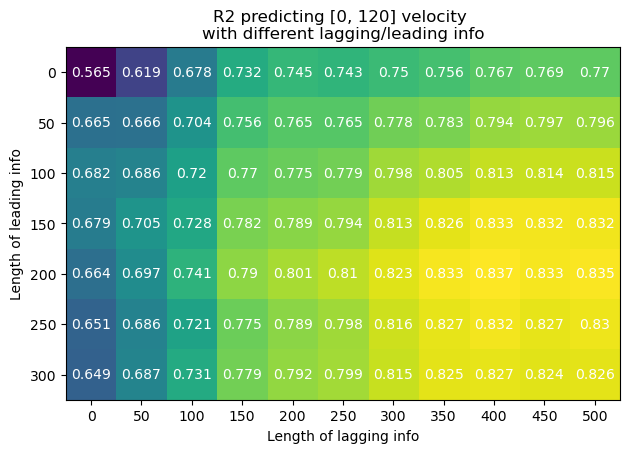

In [167]:
fig, ax = plt.subplots()
im = ax.imshow(early_multi_R2s)
ax.set_xlabel('Length of lagging info')
ax.set_ylabel('Length of leading info')

ax.set_xticks(np.arange(len(t_after_range)))
ax.set_yticks(np.arange(len(t_before_range)))
ax.set_xticklabels(labels=t_after_range)
ax.set_yticklabels(labels=t_before_range)

ax.set_title("R2 predicting [0, 120] velocity \nwith different lagging/leading info")
fig.tight_layout()
 
for i in range(len(t_before_range)):
    for j in range(len(t_after_range)):
        text = ax.text(j, i, str(int(early_multi_R2s[i, j]*1000)/1000),
                       ha="center", va="center", color="w")
plt.show()

### with PCA

In [168]:
PCA_early_multi_R2s = nans([len(t_before_range),len(t_after_range)])
PCA_early_multi_coefs = []
j,k=0,0
for time_before in t_before_range:
    coef_arr = []
    for time_after in t_after_range:
        print('Predicting with',-time_before, 'to', time_after,'ms neural data')
        
        bins_before= int(time_before/dataset_50ms.bin_width) #How many bins of neural data prior to the output are used for decoding
        bins_current= 1 #Whether to use concurrent time bin of neural data
        bins_after= int(time_after/dataset_50ms.bin_width) #How many bins of neural data after the output are used for decoding

        n_total_bins = bins_before + bins_current + bins_after

        X =  nans([n_trials,idx2-idx1,n_total_bins*n_dims])
        i = 0
        for trial_data in active_trials_pca:
            trial_hist=get_spikes_with_history(trial_data,bins_before,bins_after,bins_current)
            trial_hist = trial_hist[idx1:idx2,:,:]
            trial_hist_flat=trial_hist.reshape(trial_hist.shape[0],(trial_hist.shape[1]*trial_hist.shape[2]))
            X[i,:,:] = trial_hist_flat
            i+=1
        
        y = active_trials_vel[:,idx1:idx2,:]
    
        lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)})
        X_reshaped = X.reshape((X.shape[0]*X.shape[1]),X.shape[2])
        y_reshaped = y.reshape((y.shape[0]*y.shape[1]),y.shape[2])
        lr_all.fit(X_reshaped, y_reshaped)

        
        skf =StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)   
        true_concat = nans([(n_trials*(idx2-idx1)),2])
        pred_concat = nans([(n_trials*(idx2-idx1)),2])
        trial_save_idx = 0
        for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
            #split training and testing by trials
            X_train, X_test, y_train, y_test = process_train_test(X,y,training_set,test_set)
            lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)}) 
            lr.fit(X_train, y_train)
            y_test_predicted = lr.predict(X_test)
            n = y_test_predicted.shape[0]
            true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
            pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
            trial_save_idx += n

        sses =get_sses_pred(true_concat,pred_concat)
        sses_mean=get_sses_mean(true_concat)
        PCA_early_multi_R2s[j,k] =1-np.sum(sses)/np.sum(sses_mean)     
        print('R2:',PCA_early_multi_R2s[j,k])
        coef_arr.append(lr_all.best_estimator_.coef_)
        k += 1
    j += 1
    k = 0
    PCA_early_multi_coefs.append(coef_arr)

Predicting with 0 to 0 ms neural data
R2: 0.5260831754326215
Predicting with 0 to 50 ms neural data
R2: 0.5933361054917768
Predicting with 0 to 100 ms neural data
R2: 0.6565356872823636
Predicting with 0 to 150 ms neural data
R2: 0.7086275201859016
Predicting with 0 to 200 ms neural data
R2: 0.739161086561917
Predicting with 0 to 250 ms neural data
R2: 0.7354423330371083
Predicting with 0 to 300 ms neural data
R2: 0.7477393886860648
Predicting with 0 to 350 ms neural data
R2: 0.7541716640236436
Predicting with 0 to 400 ms neural data
R2: 0.7560582439999757
Predicting with 0 to 450 ms neural data
R2: 0.750602974376066
Predicting with 0 to 500 ms neural data
R2: 0.7559701679013338
Predicting with -50 to 0 ms neural data
R2: 0.625040444895084
Predicting with -50 to 50 ms neural data
R2: 0.6553604309263082
Predicting with -50 to 100 ms neural data
R2: 0.699890108442256
Predicting with -50 to 150 ms neural data
R2: 0.7355097607847174
Predicting with -50 to 200 ms neural data
R2: 0.762854015

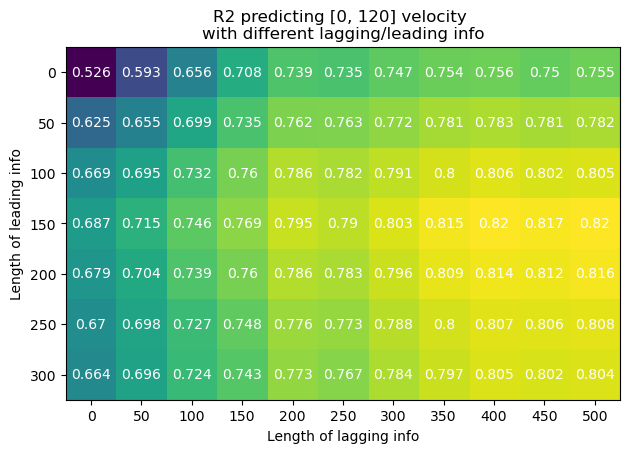

In [169]:
fig, ax = plt.subplots()
im = ax.imshow(PCA_early_multi_R2s)
ax.set_xlabel('Length of lagging info')
ax.set_ylabel('Length of leading info')

ax.set_xticks(np.arange(len(t_after_range)))
ax.set_yticks(np.arange(len(t_before_range)))
ax.set_xticklabels(labels=t_after_range)
ax.set_yticklabels(labels=t_before_range)

ax.set_title("R2 predicting [0, 120] velocity \nwith different lagging/leading info")
fig.tight_layout()

for i in range(len(t_before_range)):
    for j in range(len(t_after_range)):
        text = ax.text(j, i, str(int(PCA_early_multi_R2s[i, j]*1000)/1000),
                       ha="center", va="center", color="w")
plt.show()

## Whole

### with Neurons

In [14]:
data_range = [-300,700]
pred_start = -100
pred_end = 500

idx1 = int((pred_start - data_range[0])/dataset_50ms.bin_width)
idx2 = int(n_timepoints - (data_range[1]-pred_end)/dataset_50ms.bin_width)

t_before_range = range(0,201,50);
t_after_range = range(0,201,50);

whole_multi_R2s = nans([len(t_before_range),len(t_after_range)])
whole_multi_coefs = []
j,k=0,0
for time_before in t_before_range:
    coef_arr = []
    for time_after in t_after_range:
        print('Predicting with',-time_before, 'to', time_after,'ms neural data')
        
        bins_before= int(time_before/dataset_50ms.bin_width) #How many bins of neural data prior to the output are used for decoding
        bins_current= 1 #Whether to use concurrent time bin of neural data
        bins_after= int(time_after/dataset_50ms.bin_width) #How many bins of neural data after the output are used for decoding

        n_total_bins = bins_before + bins_current + bins_after

        X =  nans([n_trials,idx2-idx1,n_total_bins*n_neurons])
        i = 0
        for trial_data in active_trials_neuron:
            trial_hist=get_spikes_with_history(trial_data,bins_before,bins_after,bins_current)
            trial_hist = trial_hist[idx1:idx2,:,:]
            trial_hist_flat=trial_hist.reshape(trial_hist.shape[0],(trial_hist.shape[1]*trial_hist.shape[2]))
            X[i,:,:] = trial_hist_flat
            i+=1
        
        y = active_trials_vel[:,idx1:idx2,:]
    
        lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)})
        X_reshaped = X.reshape((X.shape[0]*X.shape[1]),X.shape[2])
        y_reshaped = y.reshape((y.shape[0]*y.shape[1]),y.shape[2])
        lr_all.fit(X_reshaped, y_reshaped)

        
        skf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)   
        true_concat = nans([(n_trials*(idx2-idx1)),2])
        pred_concat = nans([(n_trials*(idx2-idx1)),2])
        trial_save_idx = 0
        for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
            #split training and testing by trials
            X_train, X_test, y_train, y_test = process_train_test(X,y,training_set,test_set)
            lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)}) 
            lr.fit(X_train, y_train)
            y_test_predicted = lr.predict(X_test)
            n = y_test_predicted.shape[0]
            true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
            pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
            trial_save_idx += n

        sses =get_sses_pred(true_concat,pred_concat)
        sses_mean=get_sses_mean(true_concat)
        whole_multi_R2s[j,k] =1-np.sum(sses)/np.sum(sses_mean)     
        print('R2:',whole_multi_R2s[j,k])
        coef_arr.append(lr_all.best_estimator_.coef_)
        k += 1
    j += 1
    k = 0
    whole_multi_coefs.append(coef_arr)

Predicting with 0 to 0 ms neural data
R2: 0.5450211567741461
Predicting with 0 to 50 ms neural data
R2: 0.6601443817896226
Predicting with 0 to 100 ms neural data
R2: 0.7175695984706623
Predicting with 0 to 150 ms neural data
R2: 0.7443653046458667
Predicting with 0 to 200 ms neural data
R2: 0.7553212653112704
Predicting with -50 to 0 ms neural data
R2: 0.6494223535040926
Predicting with -50 to 50 ms neural data
R2: 0.722175174098617
Predicting with -50 to 100 ms neural data
R2: 0.7586709329198014
Predicting with -50 to 150 ms neural data
R2: 0.7779785481847725
Predicting with -50 to 200 ms neural data
R2: 0.7841518784284148
Predicting with -100 to 0 ms neural data
R2: 0.707596449026461
Predicting with -100 to 50 ms neural data
R2: 0.7559964896633807
Predicting with -100 to 100 ms neural data
R2: 0.7836734214664993
Predicting with -100 to 150 ms neural data
R2: 0.7970498749168343
Predicting with -100 to 200 ms neural data
R2: 0.8024922578784056
Predicting with -150 to 0 ms neural data


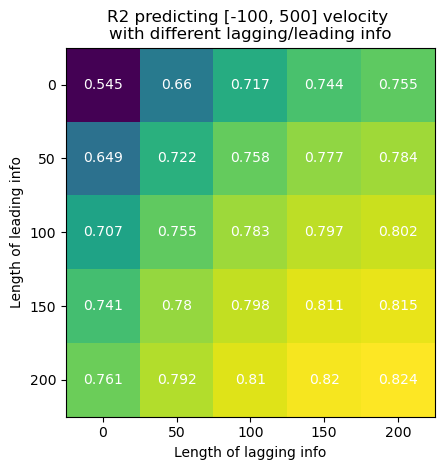

In [15]:
fig, ax = plt.subplots()
im = ax.imshow(whole_multi_R2s)
ax.set_xlabel('Length of lagging info')
ax.set_ylabel('Length of leading info')

ax.set_xticks(np.arange(len(t_after_range)))
ax.set_yticks(np.arange(len(t_before_range)))
ax.set_xticklabels(labels=t_after_range)
ax.set_yticklabels(labels=t_before_range)

ax.set_title("R2 predicting [-100, 500] velocity \nwith different lagging/leading info")
fig.tight_layout()

for i in range(len(t_before_range)):
    for j in range(len(t_after_range)):
        text = ax.text(j, i, str(int(whole_multi_R2s[i, j]*1000)/1000),
                       ha="center", va="center", color="w")
plt.show()

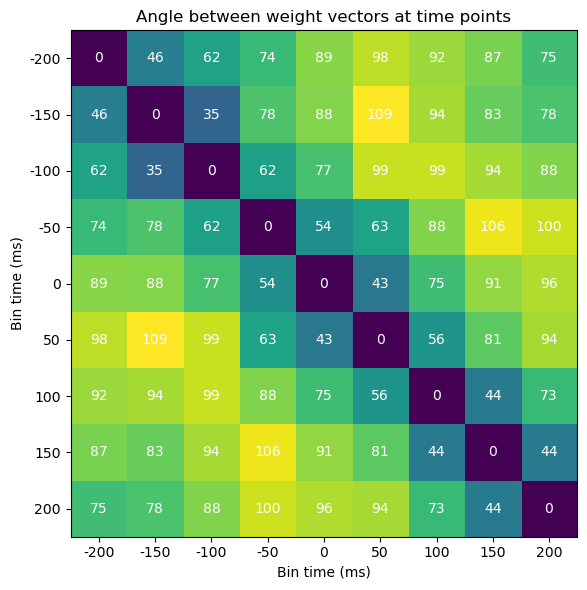

In [16]:
coef_X = whole_multi_coefs[-1][-1][0] #which entry's weights to use

t_label = np.arange(-200,201,50)

n_weights = len(t_before_range) + len(t_after_range) - 1
coef_X_reshaped = coef_X.reshape(n_weights,n_neurons)
angDist_array = nans([n_weights,n_weights])
for i in range(n_weights):
    for j in range(n_weights):
        angDist_array[i,j] = math.degrees(angle_between(coef_X_reshaped[i,:],coef_X_reshaped[j,:]))
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(angDist_array)
ax.set_xlabel('Bin time (ms)')
ax.set_ylabel('Bin time (ms)')

ax.set_xticks(np.arange(len(t_label)))
ax.set_yticks(np.arange(len(t_label)))
ax.set_xticklabels(labels=t_label)
ax.set_yticklabels(labels=t_label)

ax.set_title("Angle between weight vectors at time points")
fig.tight_layout()

for i in range(len(t_label)):
    for j in range(len(t_label)):
        text = ax.text(j, i, str(int(angDist_array[i, j])),
                       ha="center", va="center", color="w")
plt.show()


### with PCA

In [17]:
PCA_whole_multi_R2s = nans([len(t_before_range),len(t_after_range)])
PCA_whole_multi_coefs = []
j,k=0,0
for time_before in t_before_range:
    coef_arr = []
    for time_after in t_after_range:
        print('Predicting with',-time_before, 'to', time_after,'ms neural data')
        
        bins_before= int(time_before/dataset_50ms.bin_width) #How many bins of neural data prior to the output are used for decoding
        bins_current= 1 #Whether to use concurrent time bin of neural data
        bins_after= int(time_after/dataset_50ms.bin_width) #How many bins of neural data after the output are used for decoding

        n_total_bins = bins_before + bins_current + bins_after

        X =  nans([n_trials,idx2-idx1,n_total_bins*n_dims])
        i = 0
        for trial_data in active_trials_pca:
            trial_hist=get_spikes_with_history(trial_data,bins_before,bins_after,bins_current)
            trial_hist = trial_hist[idx1:idx2,:,:]
            trial_hist_flat=trial_hist.reshape(trial_hist.shape[0],(trial_hist.shape[1]*trial_hist.shape[2]))
            X[i,:,:] = trial_hist_flat
            i+=1
        
        y = active_trials_vel[:,idx1:idx2,:]
    
        lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)})
        X_reshaped = X.reshape((X.shape[0]*X.shape[1]),X.shape[2])
        y_reshaped = y.reshape((y.shape[0]*y.shape[1]),y.shape[2])
        lr_all.fit(X_reshaped, y_reshaped)

        
        skf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)   
        true_concat = nans([(n_trials*(idx2-idx1)),2])
        pred_concat = nans([(n_trials*(idx2-idx1)),2])
        trial_save_idx = 0
        for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
            #split training and testing by trials
            X_train, X_test, y_train, y_test = process_train_test(X,y,training_set,test_set)
            lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)}) 
            lr.fit(X_train, y_train)
            y_test_predicted = lr.predict(X_test)
            n = y_test_predicted.shape[0]
            true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
            pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
            trial_save_idx += n

        sses =get_sses_pred(true_concat,pred_concat)
        sses_mean=get_sses_mean(true_concat)
        PCA_whole_multi_R2s[j,k] =1-np.sum(sses)/np.sum(sses_mean)     
        print('R2:',PCA_whole_multi_R2s[j,k])
        coef_arr.append(lr_all.best_estimator_.coef_)
        k += 1
    j += 1
    k = 0
    PCA_whole_multi_coefs.append(coef_arr)

Predicting with 0 to 0 ms neural data
R2: 0.49576430499251956
Predicting with 0 to 50 ms neural data
R2: 0.6142283691435915
Predicting with 0 to 100 ms neural data
R2: 0.6719751077790675
Predicting with 0 to 150 ms neural data
R2: 0.7037174467791041
Predicting with 0 to 200 ms neural data
R2: 0.7188482551988334
Predicting with -50 to 0 ms neural data
R2: 0.6003563341036524
Predicting with -50 to 50 ms neural data
R2: 0.6780148141893236
Predicting with -50 to 100 ms neural data
R2: 0.720552928610302
Predicting with -50 to 150 ms neural data
R2: 0.7447732873923191
Predicting with -50 to 200 ms neural data
R2: 0.756109024307105
Predicting with -100 to 0 ms neural data
R2: 0.6560840551834698
Predicting with -100 to 50 ms neural data
R2: 0.7156030639569608
Predicting with -100 to 100 ms neural data
R2: 0.7495663409653442
Predicting with -100 to 150 ms neural data
R2: 0.7699084002394468
Predicting with -100 to 200 ms neural data
R2: 0.7798800166128133
Predicting with -150 to 0 ms neural data

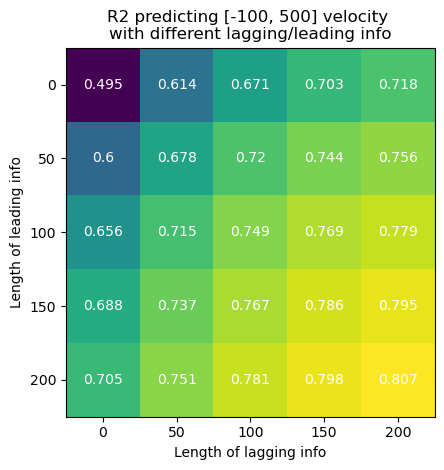

In [18]:
fig, ax = plt.subplots()
im = ax.imshow(PCA_whole_multi_R2s)
ax.set_xlabel('Length of lagging info')
ax.set_ylabel('Length of leading info')

ax.set_xticks(np.arange(len(t_after_range)))
ax.set_yticks(np.arange(len(t_before_range)))
ax.set_xticklabels(labels=t_after_range)
ax.set_yticklabels(labels=t_before_range)

ax.set_title("R2 predicting [-100, 500] velocity \nwith different lagging/leading info")
fig.tight_layout()

for i in range(len(t_before_range)):
    for j in range(len(t_after_range)):
        text = ax.text(j, i, str(int(PCA_whole_multi_R2s[i, j]*1000)/1000),
                       ha="center", va="center", color="w")
plt.show()

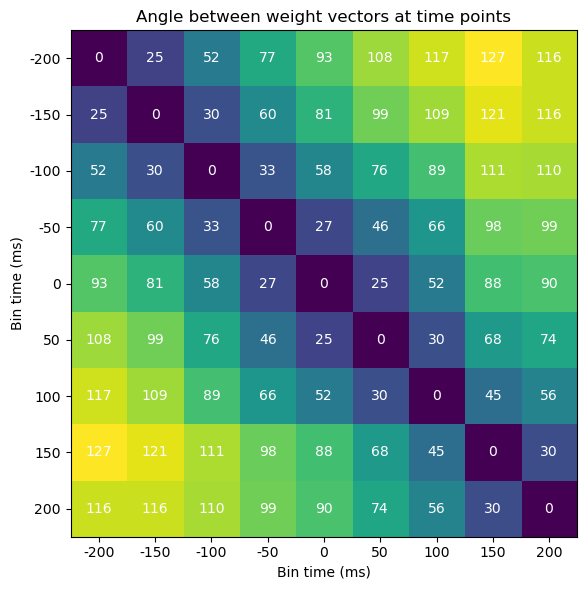

In [20]:
coef_X = PCA_whole_multi_coefs[-1][-1][0] #which entry's weights to use

t_label = np.arange(-200,201,50)

n_weights = len(t_before_range) + len(t_after_range) - 1
coef_X_reshaped = coef_X.reshape(n_weights,n_dims)
angDist_array = nans([n_weights,n_weights])
for i in range(n_weights):
    for j in range(n_weights):
        angDist_array[i,j] = math.degrees(angle_between(coef_X_reshaped[i,:],coef_X_reshaped[j,:]))
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(angDist_array)
ax.set_xlabel('Bin time (ms)')
ax.set_ylabel('Bin time (ms)')

ax.set_xticks(np.arange(len(t_label)))
ax.set_yticks(np.arange(len(t_label)))
ax.set_xticklabels(labels=t_label)
ax.set_yticklabels(labels=t_label)

ax.set_title("Angle between weight vectors at time points")
fig.tight_layout()

for i in range(len(t_label)):
    for j in range(len(t_label)):
        text = ax.text(j, i, str(int(angDist_array[i, j])),
                       ha="center", va="center", color="w")
plt.show()
